## 用神经网络逼近任意函数
这个notebook展示了使用DeepXDE逼近任意函数。

## 问题设置

我们将用神经网络逼近一个函数：

$$y = x \sin(5 x), \,\,\,\, x\in [-1,1]$$




源码：

https://github.com/lululxvi/deepxde/blob/master/examples/function/func.py

In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
def func(x):
    """
    x: array_like, N x D_in
    y: array_like, N x D_out
    """
    return x * np.sin(5 * x)


geom = dde.geometry.Interval(-1, 1)
num_train = 16
num_test = 100
data = dde.data.Function(geom, func, num_train, num_test)

In [3]:
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN([1] + [20] * 3 + [1], activation, initializer)

In [4]:
model = dde.Model(data, net)
model.compile("adam", lr=2e-4, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=20000)

Compiling model...
Building feed-forward neural network...
'build' took 0.068177 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.666008 s

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric   
0         [3.35e-01]    [2.91e-01]    [1.18e+00]    
1000      [4.98e-02]    [5.16e-02]    [4.97e-01]    
2000      [3.64e-02]    [3.86e-02]    [4.30e-01]    
3000      [1.07e-03]    [8.39e-04]    [6.34e-02]    
4000      [2.97e-04]    [2.78e-04]    [3.65e-02]    
5000      [1.13e-04]    [1.37e-04]    [2.56e-02]    
6000      [4.98e-05]    [8.65e-05]    [2.04e-02]    
7000      [2.06e-05]    [5.87e-05]    [1.68e-02]    
8000      [8.30e-06]    [4.42e-05]    [1.45e-02]    
9000      [4.15e-06]    [3.66e-05]    [1.32e-02]    
10000     [2.26e-06]    [3.18e-05]    [1.23e-02]    
11000     [1.28e-06]    [2.80e-05]    [1.16e-02]    
12000     [1.70e-06]    [2.80e-05]    [1.16e-02]    
13000     [4.04e-07]    [2.41e-05]    [1.07e-02]    
14000     [1.91e-07]    [2.24e-05]    [1.04e-02]    
15000     [1.00e-07]    [2.15e-05]    [1.01e-02]    
16000     [5.52e-08]    [2.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_history(loss_history):
    loss_train = np.sum(loss_history.loss_train, axis=1)
    loss_test = np.sum(loss_history.loss_test, axis=1)

    plt.figure(figsize=(10, 8))
    plt.semilogy(loss_history.steps, loss_train, label="Train loss")
    plt.semilogy(loss_history.steps, loss_test, label="Test loss")
    for i in range(len(loss_history.metrics_test[0])):
        plt.semilogy(
            loss_history.steps,
            np.array(loss_history.metrics_test)[:, i],
            label="Test metric",
        )
    plt.xlabel("Steps")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

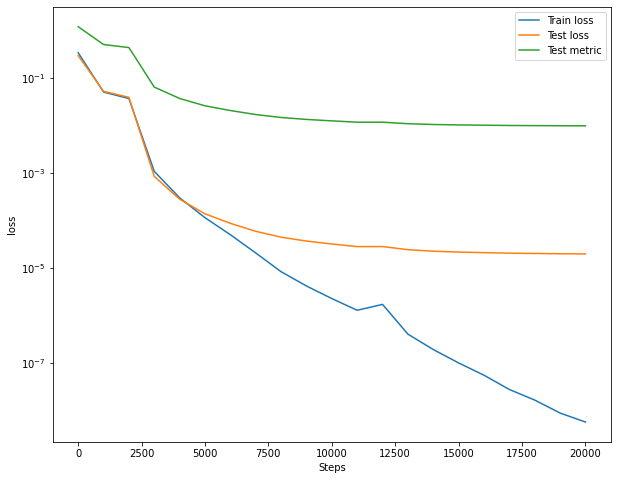

In [6]:
plot_loss_history(losshistory)

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def _pack_data(train_state):
    def merge_values(values):
        if values is None:
            return None
        return np.hstack(values) if isinstance(values, (list, tuple)) else values

    y_train = merge_values(train_state.y_train)
    y_test = merge_values(train_state.y_test)
    best_y = merge_values(train_state.best_y)
    best_ystd = merge_values(train_state.best_ystd)
    return y_train, y_test, best_y, best_ystd

def plot_best_state(train_state):
    if isinstance(train_state.X_train, (list, tuple)):
        print(
            "Error: The network has multiple inputs, and plotting such result han't been implemented."
        )
        return

    y_train, y_test, best_y, best_ystd = _pack_data(train_state)
    y_dim = best_y.shape[1]

    idx = np.argsort(train_state.X_test[:, 0])
    X = train_state.X_test[idx, 0]
    plt.figure(figsize=(10, 6))
    for i in range(y_dim):
        if y_train is not None:
            plt.plot(train_state.X_train[:, 0], y_train[:, i], "ok", label="Train")
        if y_test is not None:
            plt.plot(X, y_test[idx, i], "-k", label="True")
        plt.plot(X, best_y[idx, i], "--r", label="Prediction")
        if best_ystd is not None:
            plt.plot(
                X, best_y[idx, i] + 2 * best_ystd[idx, i], "-b", label="95% CI"
            )
            plt.plot(X, best_y[idx, i] - 2 * best_ystd[idx, i], "-b")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

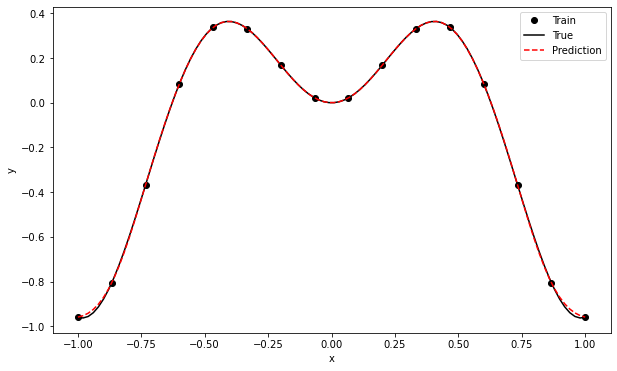

In [8]:
plot_best_state(train_state)

我们看到在边界上(x=1或-1附近)拟合的不是特别好，但是如果采样点取多一些，情况会变好。

## 学到更多

https://deepxde.readthedocs.io/en/latest/demos/function.html

### 函数逼近演示

下面是一些学习功能的演示。

#### 函数逼近

- [从数据集中学习函数](https://github.com/lululxvi/deepxde/blob/master/examples/function/dataset.py)
- [从公式中学习一个函数](https://github.com/lululxvi/deepxde/blob/master/examples/function/func.py)

#### 不确定性量化

- [学习具有不确定性量化的函数](https://github.com/lululxvi/deepxde/blob/master/examples/function/func_uncertainty.py)

#### 多保真学习

- [从公式中进行多保真学习](https://github.com/lululxvi/deepxde/blob/master/examples/function/mf_func.py)
- [从数据集中进行多保真学习](https://github.com/lululxvi/deepxde/blob/master/examples/function/mf_dataset.py)